In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import os
import random
from pypet import Environment, Trajectory, cartesian_product

import helper_functions as helper

In [156]:
with open('data_path.txt', 'r') as f:
    data_path = f.readline()
    steering_data_path = os.path.join(data_path, 'steering')
    hdf_path = os.path.join(data_path, 'HDF')

file_path = os.path.join(steering_data_path, 'MarkkulaEtAl_BiolCyb2018_DataWithIntermittentInterpretation.mat')
data = helper.loadmat(file_path)

sightpoint_filepath = os.path.join(steering_data_path, 'PreCalculatedSightPointSignalData.mat')
sightpoint_data = helper.loadmat(sightpoint_filepath)['SSightPointPreCalc']

lk_data = data['STasks'][0]
lk_sightpoint_data = sightpoint_data.STasks[0]
lk_subjects = np.arange(1, 16)

# Prepare passive phase data

In [14]:
def get_p(sightpoint_recording, p_weights):
    near_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[0].SPathVariants.SSightPointSignals)
    nsp_angle = near_sightpoint.VSightPointAngle
    nsp_rate = near_sightpoint.VSightPointRate

    far_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[1].SPathVariants.SSightPointSignals)
    fsp_angle = far_sightpoint.VSightPointAngle
    fsp_rate = far_sightpoint.VSightPointRate
    
    p = p_weights['k_nI']*nsp_angle + p_weights['k_nP']*nsp_rate + p_weights['k_f']*fsp_rate
    
    return p

def get_passive_phase_data(data, sightpoint_data, p_weights, delay):
    passive_phases = []
    for i, driver in enumerate(data.SDrivers):
        for j, recording in enumerate(driver.SRecordings):
            # VSWRate from the original data is a bit oversmoothed, which might lead to underestimation of 
            # inter-adjustment intervals, so we try an alternative numerical differentiation algo here
            v = helper.differentiate(recording.SSignals.VTimeStamp, recording.SSignals.VSWAngle)
            
            starting_points, action_points = helper.extract_passive_phases(v)
            
            if (len(starting_points) != len(action_points)):
                raise AssertionError('Mismatch in the number of starting/action points')
            elif len(starting_points)>0:
                # we're looking at passive phases, so sensorimotor delays supposedly affect action points
                # but not starting points of passive phases. The reason is that corrective adjustments are open-loop,
                # so their final part doesn't depend on the system state. However, the end of a passive phase
                # (action point) is driven by the system state, supposedly delayed          
                # in the lane-keeping task sampling frequency was 60Hz (time step 16.7ms)
                delay_n = int(round(delay/16.7))

                delayed_ap = np.array(action_points) - delay_n
                delayed_ap[delayed_ap<=0] = 0

                t_sp = recording.SSignals.VTimeStamp[starting_points]
                t_ap = recording.SSignals.VTimeStamp[delayed_ap]

                p = get_p(sightpoint_data.SDrivers[i].SRecordings[j], p_weights)

                df = pd.DataFrame({'subject': i+1,
                                   'recording': j+1,
                                   'passive_phase_number': np.arange(1, len(starting_points)+1),
                                   'idx_sp': starting_points,
                                   'idx_ap': action_points,
                                   't_sp': t_sp, 
                                   't_ap': t_ap,
                                   'p_sp': p[starting_points],
                                   'p_ap': p[delayed_ap]})

                passive_phases.append(df)
    
    passive_phases = pd.concat(passive_phases).set_index(['subject', 'recording'], drop=False)
    
    # there are problematic passive phases consisting of just one data point, we discard them
    # with the sampling rate of 60Hz those are apparently false alarms
    passive_phases = passive_phases[passive_phases.idx_ap - passive_phases.idx_sp > 1]
    
    passive_phases['delta_t'] = passive_phases.t_ap - passive_phases.t_sp
    
    # we discard outliers with extreme delta_t (>4s without steering adjustments, just about 40 of them in total)
    passive_phases = passive_phases[(passive_phases.delta_t<4)]
    passive_phases['log_delta_t'] = np.log(passive_phases.delta_t)   
    passive_phases['p_sp_decile'] = pd.qcut(passive_phases['p_sp'], 10, labels=np.arange(1,11))
    return passive_phases

def save_passive_phases_to_csv(data, sightpoint_data, task, p_weights, delay):
    passive_phases = get_passive_phase_data(data, sightpoint_data, p_weights, delay)
    passive_phases.to_csv(os.path.join(data_path, 'passive_phases_%s.csv' % (task)), index=False)

In [15]:
p_weights = {'k_nI': 0.02, 'k_nP': 0.2, 'k_f': 1.6}
delay = 0 #ms

save_passive_phases_to_csv(lk_data, lk_sightpoint_data, 'lk', p_weights, delay)
# save_passive_phases_to_csv(cd_data, cd_sightpoint_data, 'cd', p_weights)

# Check passive phase data

In [116]:
passive_phases_lk = pd.read_csv(os.path.join(data_path, 'passive_phases_lk.csv'), index_col=None)
passive_phases_lk = passive_phases_lk.set_index(['subject', 'recording', 'passive_phase_number'], drop=False)
len(passive_phases_lk)

# passive_phases_cd = pd.read_csv(os.path.join(data_path, 'passive_phases_cd.csv'), index_col=None)

# there is an outlier in the circular driving task, better exclude it
# print(passive_phases_cd[passive_phases_cd.p_sp>2])
# passive_phases_cd = passive_phases_cd[passive_phases_cd.p_sp<2]

1892

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


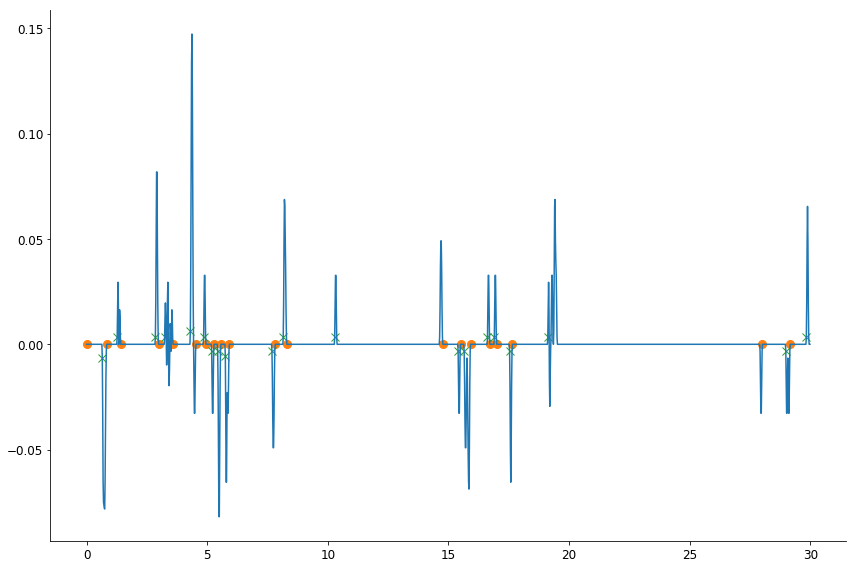

In [6]:
def plot_example_sw_rate(drivers, passive_phases, subject=1, recording=1):
    data = drivers.SDrivers[subject-1].SRecordings[recording-1]
    t = data.SSignals.VTimeStamp
    x = data.SSignals.VSWAngle
    v = helper.differentiate(t, x)

    ap_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_ap.values
    sp_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_sp.values

    fig, ax = plt.subplots(figsize=(12,8))    
    ax.plot(t[sp_idx], v[sp_idx], ls='', marker='o', ms=8, color='C1')
    ax.plot(t[ap_idx], v[ap_idx], ls='', marker='x', ms=8, color='C2')
    ax.plot(t, v)
#     ax.set_xlim([0,5])
    
plot_example_sw_rate(lk_data, passive_phases_lk, subject=1, recording=2)
# plot_example_sw_rate(cd_data, passive_phases_cd, subject=1, recording=2)

# Exploring $\Delta_t$ distributions

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


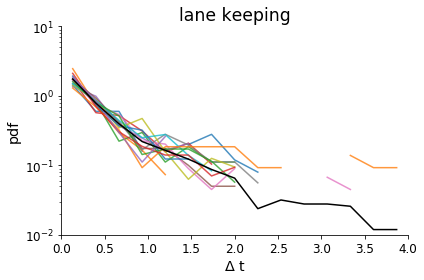

In [47]:
def plot_delta_t_hist(data, task, xlim):
    ax = helper.plot_pdf(data=data, var='delta_t', bins=np.linspace(0, xlim[1], 16))
#     ax = helper.plot_pdf(data=data, var='delta_t', bins=25)
    ax.set_xlabel('$\Delta$ t')
#     ax.set_ylabel('pdf')
    ax.set_xlim(xlim)
    ax.set_ylim((0.01, 10))
    ax.set_title(task)
    
    return ax
    
ax = plot_delta_t_hist(passive_phases_lk, 'lane keeping', (0., 4))
plt.savefig('figures/delta_t_pdf_lk.png')

# ax = plot_delta_t_hist(passive_phases_cd, 'circular driving', (0., 2))
# plt.savefig('figures/delta_t_pdf_cd.png')

# $p_{AP}$ distributions

(0.1, 500)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


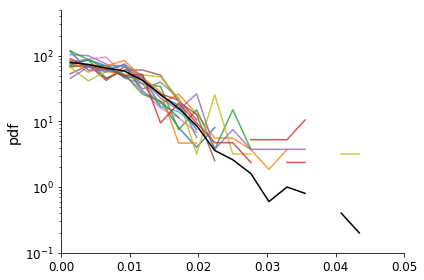

In [48]:
ax = helper.plot_pdf(data=abs(passive_phases_lk), var='p_ap', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

# ax = helper.plot_pdf(data=passive_phases_cd, var='p_ap', bins=np.linspace(0, 0.3, 20))
# ax.set_xlim((0.0, 0.3))
# ax.set_ylim((0.05, 50))

# $p_{SP}$ distributions

(0.1, 500)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


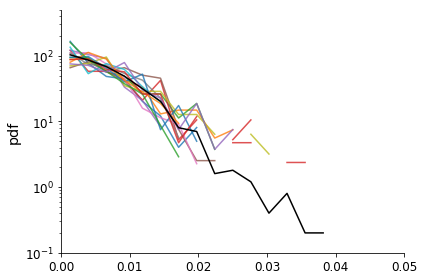

In [49]:
ax = helper.plot_pdf(data=abs(passive_phases_lk), var='p_sp', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

# ax = helper.plot_pdf(data=passive_phases_cd, var='p_sp', bins=np.linspace(0, 0.3, 20))
# ax.set_xlim((0.0, 0.3))
# ax.set_ylim((0.05, 50))

# Joint $p_{SP}$ vs $\Delta_t$ distributions

Assuming $p_{SP}$ is driving the decision to start steering, how does the adjustment initiation time change with $p_{SP}$?

In the lane keeping task, $\Delta_t$ generally decreases with $p_{SP}$

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


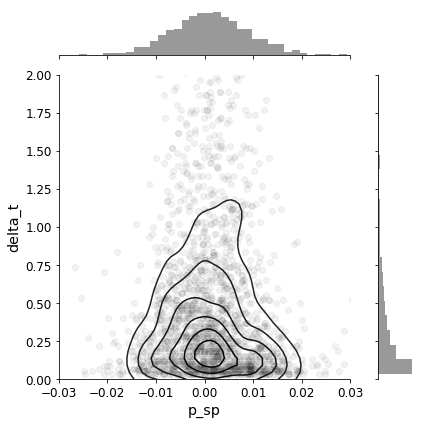

In [50]:
(sns.jointplot(x=passive_phases_lk.p_sp, y=passive_phases_lk.delta_t, alpha=0.05, xlim=(-0.03, 0.03), ylim=(0, 2), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=7, color='k'))

To make this clearer, we'll plot average $\Delta_t$ for every decile of $p_{SP}$.

In the lane keeping task, $\Delta_t$ decreases from about 700-800ms for the least pressing situations to about 200ms for situations where the $p_{SP}$ is very large already in the beginning of a passive phase.

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


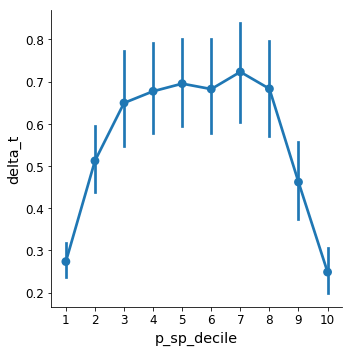

In [51]:
sns.catplot(data=passive_phases_lk, x='p_sp_decile', y='delta_t', kind='point')

# Dynamics of $p$ in the passive phase 

In [117]:
def get_p_dynamics(passive_phase, sightpoint_data):
    p_weights = {'k_nI': 0.02, 'k_nP': 0.2, 'k_f': 1.6}
    subject, recording = passive_phase.name[0]-1, passive_phase.name[1]-1
    p = get_p(sightpoint_data.SDrivers[subject].SRecordings[recording], p_weights=p_weights)
    
    return pd.Series(p[int(passive_phase.idx_sp):int(passive_phase.idx_ap+1)])
    
p_dynamics_lk = passive_phases_lk.groupby(['subject', 
                                           'recording', 
                                           'passive_phase_number']).apply(lambda p: 
                                                                          get_p_dynamics(p, lk_sightpoint_data))
p_dynamics_lk.index = p_dynamics_lk.index.droplevel(3)

def get_adjustment_dynamics(passive_phase, driving_data):
    subject, recording = passive_phase.name[0]-1, passive_phase.name[1]-1
    recording_data = driving_data.SDrivers[subject].SRecordings[recording]
    sw_rate = helper.differentiate(recording_data.SSignals.VTimeStamp, recording_data.SSignals.VSWAngle)
    
    return pd.Series(sw_rate[int(passive_phase.idx_sp):int(passive_phase.idx_ap+1)])
    
v_dynamics_lk = passive_phases_lk.groupby(['subject', 'recording', 
                                       'passive_phase_number']).apply(lambda p: 
                                                                      get_adjustment_dynamics(p, lk_data))
v_dynamics_lk.index = v_dynamics_lk.index.droplevel(3)

v_sign = np.sign(v_dynamics_lk.groupby(v_dynamics_lk.index.names).last())
passive_phases_lk = passive_phases_lk.join(((passive_phases_lk.p_ap * v_sign > 0)).rename('is_correct'))

C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'subject' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'recording' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'passive_phase_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: 'subject' is both an index level and a column label.
Defaulting to column, but th

The number of trials with mismatches between deviation and adjustment direction is actually pretty high

In [119]:
len(passive_phases_lk[~passive_phases_lk.is_correct])/len(passive_phases_lk)

0.17600422832980972

For now, we might want to keep only trials where corrective adjustment is in line with the deviation (as expressed in $p$). The trials with a mismatch might be accounted for by error trials in a DDM

In [56]:
# p_dynamics_lk = p_dynamics_lk[(passive_phases_lk.p_ap * v_sign > 0)]
# passive_phases_lk = passive_phases_lk[(passive_phases_lk.p_ap * v_sign > 0)]

In [25]:
def plot_p(p_dynamics, v_sign):
    threshold = 0.002
    # if p decreases over time, color is blue
    if (p_dynamics.iloc[-1] - p_dynamics.iloc[0]< -threshold):
        color='C0'
    # if p increases over time, color is orange
    elif(p_dynamics.iloc[-1] - p_dynamics.iloc[0] > threshold):
        color='C1'
    # if it's more-less same, color is grey
    else:
        color='grey'
            
    plt.plot(np.linspace(0, len(p_dynamics)/60, len(p_dynamics)), p_dynamics, color=color, alpha=0.6)
    
    # if the corrective adjustment is left (negative), the color is blue, if right then the color is orange
    marker, marker_color = ('^', 'C0') if v_sign.loc[p_dynamics.name] < 0 else ('v', 'C1')
    plt.plot([len(p_dynamics)/60], [p_dynamics[-1]], color=marker_color, marker=marker, ms='3', ls='', alpha=0.8)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


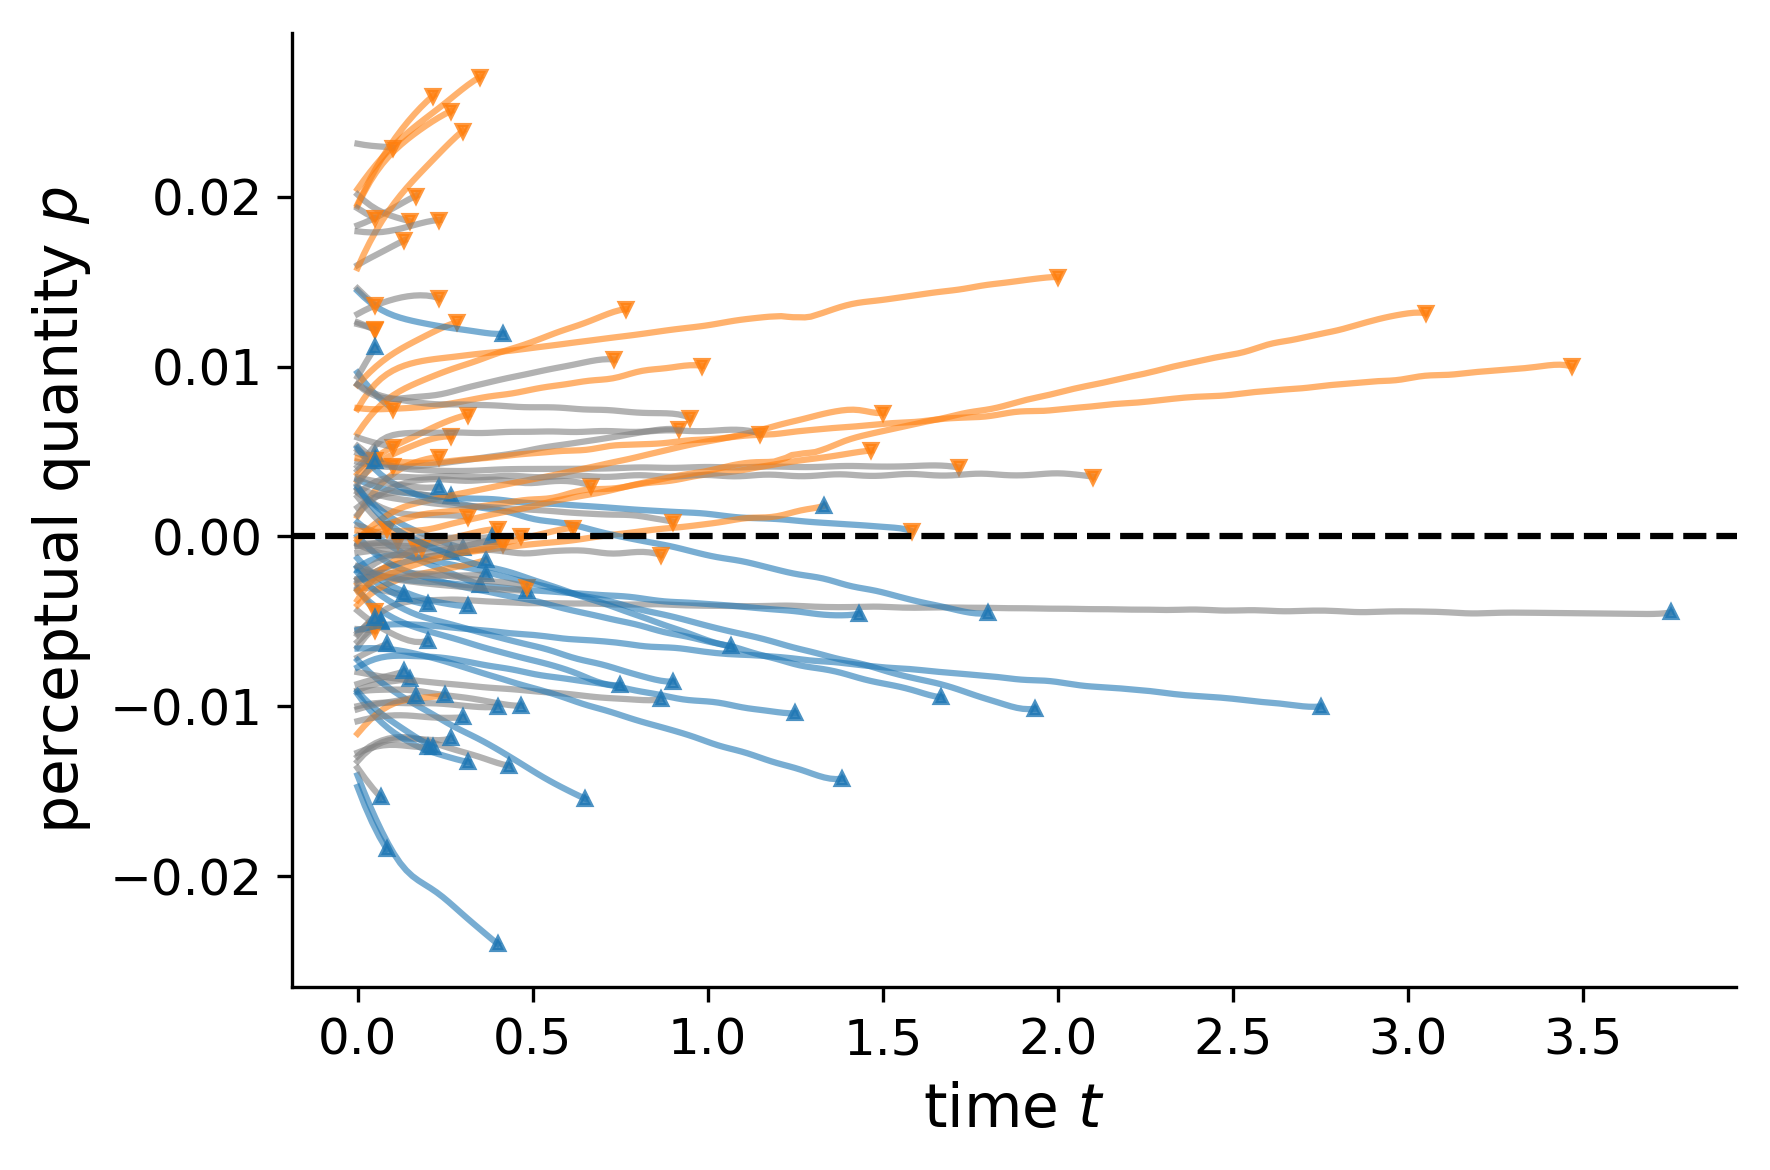

In [26]:
subj = 3

fig, ax = plt.subplots(1, dpi=300)
p_dynamics_lk[subj].groupby(['recording', 'passive_phase_number']).apply(lambda p: plot_p(p, v_sign[subj]));

ax.axhline(0.0, color='k', ls='--')
ax.set_xlabel('time $t$')
ax.set_ylabel('perceptual quantity $p$');

# DDM modeling

Our approach is to simulate evidence accumulation for each observed passive phase ("trial") multiple times and choose the DDM parameters which generate action points/$\Delta_t$ closest to the ones produced by the drivers.

First, we'd need to be able to extrapolate the dynamics of $p$ in case the accumulator doesn't reach either boundary by the time a driver made their decision

In [120]:
def interp_p(t_exp, p_exp, vectorized=False):
    # here we take the last 30% of each trial and fit a linear function 
    # to p dynamics to be able to extrapolate beyond observed action point
    # caution: this function is not vectorized because it's going to be used in step-by-step numerical simulations
    # so plotting won't work
    lower_bound = max(int(len(t_exp)*0.3), 2)
    slope, intercept, _, _, _ = sp.stats.linregress(x=t_exp[-lower_bound:], y=p_exp[-lower_bound:])
    
    if not vectorized:
        return lambda t: np.interp(t, t_exp, p_exp) if t<t_exp.max() else intercept + t*slope
    else:
        return lambda t: np.concatenate([np.interp(t[t<t_exp.max()], t_exp, p_exp), 
                                     intercept + t[t>=t_exp.max()]*slope])

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


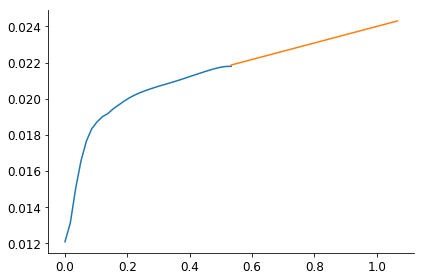

In [121]:
p_exp = p_dynamics_lk.loc[1,1,1]
t_exp = np.linspace(0, len(p_exp)/60, len(p_exp))
t_extra = np.linspace(len(p_exp)/60, 2*len(p_exp)/60, len(p_exp))

p_extra = interp_p(t_exp, p_exp, vectorized=True)

plt.plot(t_exp, p_exp)
plt.plot(t_extra, p_extra(t_extra))

First, for a given trajectory of $p$ and a given set of DDM params $A, c$ generate and visualize 100 activations by DDM

In [122]:
def plot_ddm_traces(xs, ns, t_exp, p_exp):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)

    for n in ns:
        axes.flatten()[0].plot(xs.loc[n].t, xs.loc[n].x, color='C0')
        axes.flatten()[1].plot(xs.loc[n].t, xs.loc[n].p, color='C0')
        axes.flatten()[1].plot([xs.loc[n].t.values[-1]], [xs.loc[n].p.values[-1]], color='C0', marker='o')
    
    axes.flatten()[1].plot(t_exp, p_exp, color='C1')
    axes.flatten()[2].hist(xs.groupby('n').t.last())    

    axes.flatten()[0].set_ylabel('evidence $x$')
    axes.flatten()[1].set_ylabel('perceptual information $p$')
    axes.flatten()[2].set_ylabel('pdf $P(p=p_{ap})$')    
    
    for ax in axes.flatten():
        ax.set_xlabel('time $t$')
        ax.axvline(t_exp[-1], color='C1', ls='--')
        ax.axvline(xs.groupby('n').t.last().mean(), color='C0', ls='--')    
    
    axes.flatten()[1].set_title('Correct rate$=%.2f$, mean $\Delta_t = %.2f$' % (xs.groupby('n').is_correct.last().mean(), 
                                                               xs.groupby('n').t.last().mean()))
    
    return fig

In [123]:
def dx(A, A_norm, c, dt):
    return (A/A_norm)*dt + c*np.random.randn()*np.sqrt(dt)

def run_trial(c, b, p, p_exp_mean):
    # Expected first passage time is b/<A/A_norm> = b, so we want there to be on average 25 integration steps
    dt = b/25

    ts = [0]
    ps = [p(0)]
    xs = [0]
    
    while abs(xs[-1]) < b:               
        t = ts[-1] + dt
        
        # stimulus strength $p$ at time t
        ps.append(p(t))
        
        # accumulated evidence $x$ at time t
        xs.append(xs[-1] + dx(p(t), p_exp_mean, c, dt))
        ts.append(t)
        
    return np.array(ts), np.array(xs), np.array(ps)

def run_sim(c, b, p_exp, p_exp_mean, n_sim):
    trials = []
    t_exp = np.linspace(0, len(p_exp)/60, len(p_exp))
#     p = lambda t: interp_p(t, t_exp, p_exp)
    
    p = interp_p(t_exp, p_exp)
    
    for n in range(n_sim):        
        ts, xs, ps = run_trial(c, b, p, p_exp_mean)
        # if the sign of boundary reached by accumulator is the same as the sign of $p$, we count a trial as correct
        is_correct = (xs[-1]*ps[-1] > 0)
        
        # n : simulation number 
        # t : time
        # x: accumulated evidence at time t
        # p: perceptual quantity at time t
        # is_correct: whether "correct" boundary is hit (-b for p[-1]<0, +b for p[-1]>0)
        trials.append(pd.DataFrame(data={'n': n, 't': ts, 'x': xs, 'p': ps, 'is_correct': is_correct}))
    return pd.concat(trials).set_index(['n'])

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


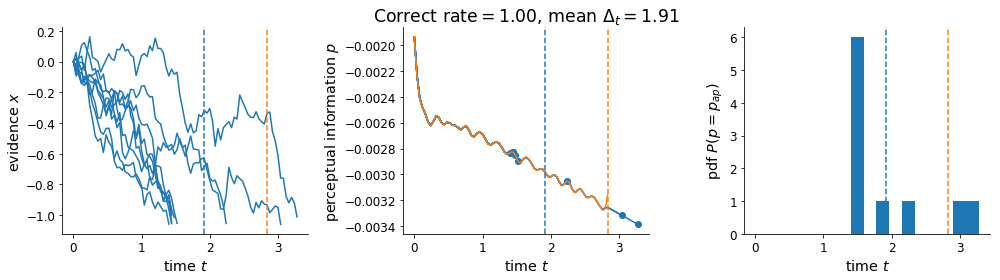

In [124]:
c = 0.3
b = 1

p_exp = p_dynamics_lk.loc[1,1,9]
t_exp = np.linspace(0, len(p_exp)/60, len(p_exp))

n_sim = 10

xs = run_sim(c=c, b=b, p_exp=p_exp, p_exp_mean=np.mean(abs(p_dynamics_lk)), n_sim=n_sim)

ns = range(1, n_sim)
ax = plot_ddm_traces(xs, ns, t_exp, p_exp)

# sim_results = run_sim(c=0.1, b=1, p_exp=p_exp, n_sim=10)
# for n, sim_result in sim_results.groupby('n'):
#     plt.plot(sim_result.t, sim_result.x, alpha=0.6)

Now let's simulate DDM 10 times for each trial

In [125]:
%%time
for name, p_exp in p_dynamics_lk.groupby(p_dynamics_lk.index.names):
    xs = run_sim(c=c, b=b, p_exp=p_exp, p_exp_mean=np.mean(abs(p_dynamics_lk)), n_sim=10)

Wall time: 24 s


Total simulation time will take the above times the number of tested parameter combinations. If we have 4-by-4 grid search of 2d parameter space, that's manageable, about 8-15 min. If however we include $k$ as parameters of the perceptual variable used by accumulator, we'll have $4^5 \approx 1000$ parameter combinations, or 15 hours, which is pretty expensive in terms of time but still manageable.

Now let's try to record integration dynamics per each simulation per each trial to an HDF file

In [94]:
def run_ddm(traj, p_dynamics_exp):
    p_exp_mean = np.mean(abs(p_dynamics_exp))
    sim_results = p_dynamics_exp.groupby(p_dynamics_exp.index.names).apply(
        lambda p_exp: run_sim(c=traj.c, b=traj.b, p_exp=p_exp, p_exp_mean=p_exp_mean, n_sim=10))
    
    # in traj results we will store everything that is required to reconstruct model behavior for a given parameter set
    sp = sim_results.groupby(sim_results.index.names).first().p
    ap = sim_results.groupby(sim_results.index.names).last().p
    delta_t = sim_results.groupby(sim_results.index.names).last().t - sim_results.groupby(sim_results.index.names).first().t 
    is_correct = sim_results.groupby(sim_results.index.names).last().is_correct
    
    result = pd.DataFrame({'sp': sp, 
                           'ap': ap,
                           'delta_t': delta_t,
                           'is_correct': is_correct}, index=sp.index)
    
    traj.f_add_result('sim_result', result, comment='Full dataframe')
#     traj.f_add_result('sp', sp, comment='Starting points')
#     traj.f_add_result('ap', ap, comment='Action points')
#     traj.f_add_result('delta_t', delta_t, comment='Inter-adjustment interval')
#     traj.f_add_result('is_correct', is_correct, comment='True if the boundary hit by accumulator corresponds to the sign of p')
    
def explore(hdf_path, p_dynamics_exp):    
    c_grid = [0.1, 0.5, 1.0, 2.0]
    b_grid = [0.1, 0.5, 1.0, 2.0]

    env = Environment(trajectory='DDM_steering', filename=hdf_path, file_title='DDM_steering', overwrite_file=True)

    traj = env.trajectory

    traj.f_add_parameter('c', 1.0, comment='Diffusion rate')
    traj.f_add_parameter('b', 1.0, comment='DDM decision boundary')

    traj.f_explore(cartesian_product({'c':c_grid, 'b':b_grid}))
    env.run(lambda traj: run_ddm(traj, p_dynamics_exp=p_dynamics_exp))

In [95]:
%%time
explore(hdf_path=os.path.join(hdf_path, '%s.hdf5' % ('ddm_steering')), p_dynamics_exp=p_dynamics_lk)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_steering.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     You specified ``overwrite_file=True``, so I deleted the file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_steering.hdf5`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `DDM_steering`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `DDM_steering`.
MainProcess pypet.environment.Environment INFO     
*****************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Start storing Trajectory `DDM_steering`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `config`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished storing Trajectory `DDM_steering`.
MainProcess pypet.environment.Environment INFO     
************************************************************
FINISHED FINAL STORING of trajectory
`DDM_steering`.
************************************************************

MainProcess pypet.environment.Environment INFO     All runs of trajectory `DDM_steering` were completed successfully.


Wall time: 8min 2s


In [155]:
def get_model_pdf(model_data, bandwidth=0.2):
    var1, var2 = model_data.sp, model_data.delta_t    
    kde = stats.gaussian_kde(np.vstack([var1, var2]))    
    return kde.evaluate

def get_log_likelihood(model_pdf, exp_data):
    var1, var2 = exp_data.p_sp, exp_data.delta_t
    min_p = 1/len(exp_data)
    exp_data_probs = model_pdf(np.vstack([var1, var2]))
    exp_data_probs[exp_data_probs<min_p] = min_p
    return np.log(exp_data_probs).sum()

def plot_pdf(x, ax=None, ls='-'):
    hist, bins = np.histogram(x, bins=30, density=True)
    # only plot bins with 5 or more data points
    hist[hist<5/len(x)] = np.nan
    ax.plot((bins[1:] + bins[:-1])/2, hist, ls=ls, alpha=0.5, color='k')
    
    ax.set_ylabel('pdf')
#     ax.set_yscale('log')
#     ax.set_ylim((0.005, 25))

    return ax

def plot_2d_hist(var1, var2, ax, show_data=False, show_pdf=True, cmap='viridis'):
    values = np.vstack([var1, var2])

    [xmin, xmax] = var1.quantile([0.0, 0.99])
    [ymin, ymax] = var2.quantile([0.0, 0.99])

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    pdf = stats.gaussian_kde(values)
    Z = np.reshape(pdf(positions).T, X.shape)
    if show_pdf:
        CS = ax.contour(X, Y, Z, cmap=cmap)
    
    if show_data:
        ax.plot(var1, var2, 'k.', markersize=3, alpha=0.2)
        
    ax.set_xlabel('passive phase onset')
    ax.set_ylabel('$\Delta_t$')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    return ax

def plot_explore(filename, exp_passive_phases, grid, kind='2d'):
    traj = Trajectory('DDM_steering')
    traj.f_load(filename=filename, index=-1, load_parameters=2, load_results=2)

    fig, axes = plt.subplots(grid, grid, figsize=(4*(grid),3*(grid)), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.reshape(-1)):        
        run = traj.f_get_run_names()[i]
        model_data = traj[run].result
        model_data['sp_decile'] = pd.qcut(model_data['sp'], 10, labels=np.arange(1,11))
        
        model_data_correct, model_data_error = model_data[model_data.is_correct], model_data[~model_data.is_correct]
        exp_data_correct, exp_data_error = exp_passive_phases[exp_passive_phases.is_correct], exp_passive_phases[~exp_passive_phases.is_correct]
        
        if kind == '2d':
            plot_2d_hist(model_data_correct.sp, model_data_correct.delta_t, ax, show_data=False, cmap='viridis')        
            plot_2d_hist(exp_data_correct.p_sp, exp_data_correct.delta_t, 
                         ax, show_data=True, show_pdf=False, cmap='magma')
            ax.text(0.015, 2.5, 'DDM error rate %.2f' % (1-model_data.is_correct.mean()))
            ax.set_xlim((-0.03, 0.03))
            ax.set_ylim((0.0, 3.0))
        elif kind == '1d':                        
            sns.pointplot(data = model_data,
                          x='sp_decile', 
                          y='delta_t',                          
                          hue='is_correct', linestyles=['-', '-'],
                          ax=ax, palette =['C1', 'C0'])
            sns.pointplot(data = exp_passive_phases,
                          x='p_sp_decile', 
                          y='delta_t',                          
                          hue='is_correct', linestyles=['--', '--'],
                          ax=ax, palette =['C1', 'C0'])

            ax.text(0.015, 7.5, 'DDM error rate %.2f' % (1-model_data.is_correct.mean()))
            ax.set_ylim((0.0, 3.0))
            ax.get_legend().remove()
            
        model_pdf_correct = get_model_pdf(model_data_correct)
        model_pdf_error = get_model_pdf(model_data_error)
        log_lik_correct = get_log_likelihood(model_pdf_correct, exp_data_correct)
        log_lik_error = get_log_likelihood(model_pdf_error, exp_data_error)
#         log_lik_str = r', $l_1 = %.0f, l_2 = %.0f$' % (log_lik_correct, log_lik_error)
        log_lik_str = r', $l = %.0f$' % (log_lik_correct + log_lik_error)
        
        title = (traj.f_get_run_information(run)['parameter_summary'] + log_lik_str).replace("  ", "")
        ax.set_title(title, )

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_steering.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `DDM_steering`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `2`.
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


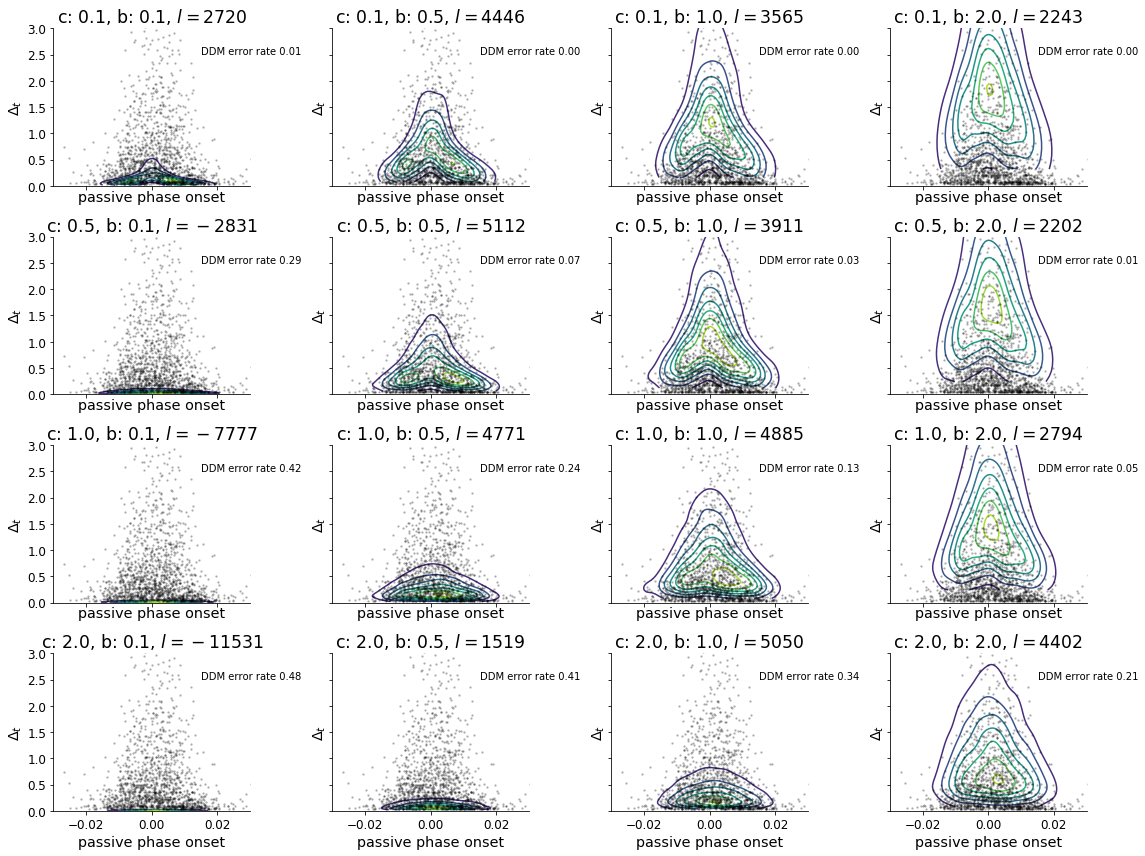

In [136]:
plot_explore(os.path.join(hdf_path, 'ddm_steering.hdf5'), passive_phases_lk, 4, kind='2d')

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_steering.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `DDM_steering`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `2`.
C:\Users\Arkady\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Arkady\Anaconda3\lib\site-p

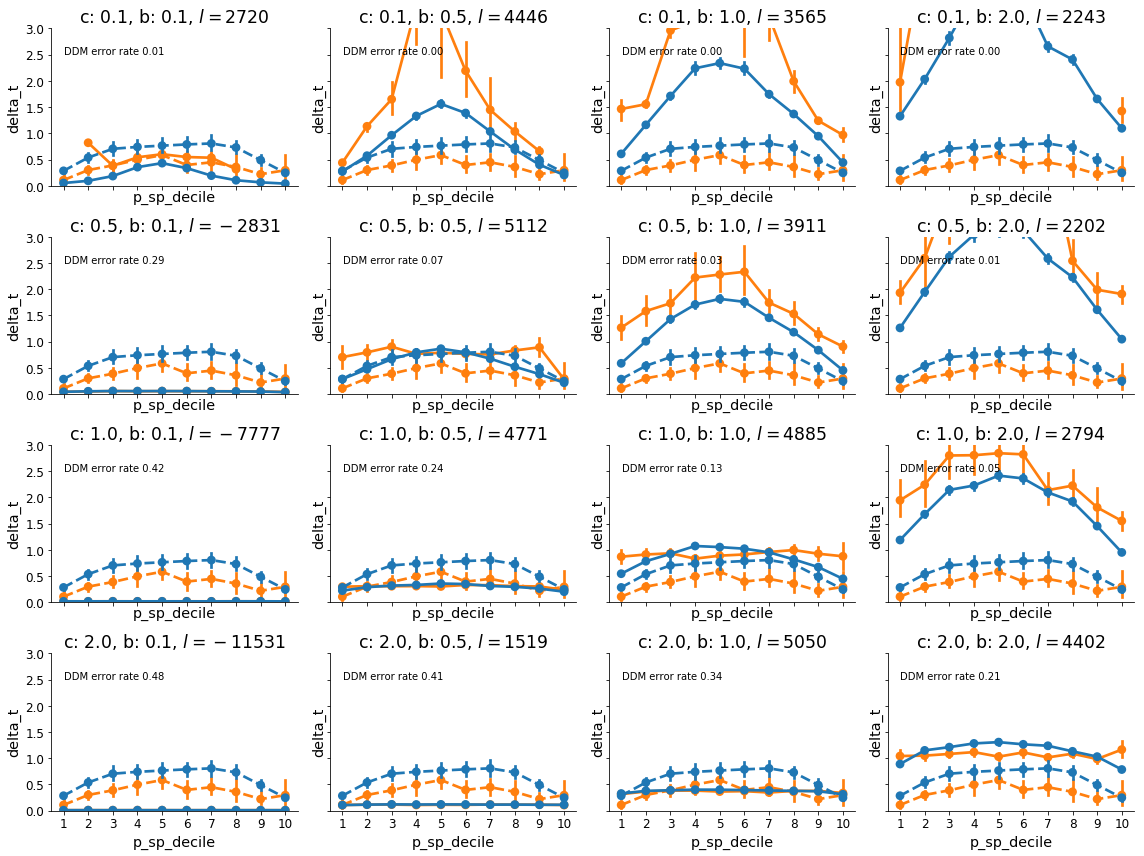

In [154]:
plot_explore(os.path.join(hdf_path, 'ddm_steering.hdf5'), passive_phases_lk, 4, kind='1d')